# Small Random Search

In [1]:
from utils.config import automl_config
import numpy as np
from utils.callbacks import Verbose
from dataset.dataloader import LoadDataLoader
from dragon.utils.tools import logger
from utils.trainer import Trainer

config = automl_config
config['filename'] = 'dataset/data.csv'
config['target'] = 'conso_rte'
config['FeaturesCallbacks'].append(Verbose(logger))
config['WeightsCallbacks'].append(Verbose(logger))
config['Complexity'] = 2
data_loader = LoadDataLoader(config)
# Number of epochs to train the features
config['MaxFeaturesEpochs'] = 2
sp = config['SearchSpace'](config)
trainer = Trainer(data_loader)
trainer.labels = [e.label for e in sp]
# Number of epochs to train the models weights
trainer.config['Ep'] = 10

We randomly generate and train models:

In [13]:
models = sp.random(5)

Model 1

Features:  [4.217023755985103, -5.138063081102331, 6.356021228389185, -9.899368832226772, -0.42845572552704425, 8.848729649832418, -3.8668241807026575, 5.928901289835567, -2.5506583386413944, -2.2099051037474604, 7.679412491982735, 3.851132521837087, 5.0670426967131394, 3.3256320659191516, 5.267621224694533, -4.857042557486206, -5.391524490053583]


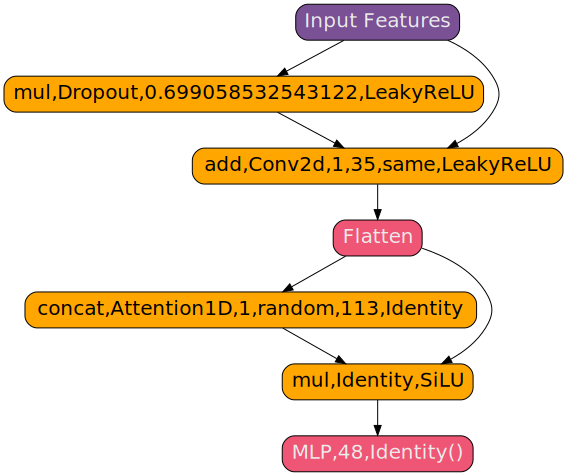

In [14]:
from dragon.utils.plot_functions import draw_graph, get_name_features, str_operations
m = models[1]
features = get_name_features(m[0], automl_config)
print("Features: ", features)
m1 = m[1].matrix
n1 = str_operations(m[1].operations)
m2 = m[2].matrix
n2 = str_operations(m[2].operations)

G = draw_graph(n1, m1, n2, m2, "dataset/save/figures/small_example_1")
G

In [15]:
loss, model = trainer.train_and_test(m)

2024-04-09 08:42:08,222 | INFO | Epoch 0 ==> Opt Features train loss: 0.12484589219093323, val loss: 0.014547020196914673
2024-04-09 08:42:08,223 | INFO | Epoch 0 ==> Opt Features train loss: 0.12484589219093323, val loss: 0.014547020196914673
2024-04-09 08:42:49,596 | INFO | Epoch 1 ==> Opt Features train loss: 0.009358133189380169, val loss: 0.010507257655262947
2024-04-09 08:42:49,597 | INFO | Epoch 1 ==> Opt Features train loss: 0.009358133189380169, val loss: 0.010507257655262947
2024-04-09 08:43:14,310 | INFO | Epoch 0 ==> Opt Weights train loss: 0.03029516153037548, val loss: 0.021614646539092064
2024-04-09 08:43:14,311 | INFO | Epoch 0 ==> Opt Weights train loss: 0.03029516153037548, val loss: 0.021614646539092064
2024-04-09 08:43:36,874 | INFO | Epoch 1 ==> Opt Weights train loss: 0.017058193683624268, val loss: 0.017024029046297073
2024-04-09 08:43:36,874 | INFO | Epoch 1 ==> Opt Weights train loss: 0.017058193683624268, val loss: 0.017024029046297073
2024-04-09 08:44:11,014 

# Test with a random Forest

In [4]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor()
dataset = data_loader.get_dataset("train", False)
trainset = data_loader.get_dataset('train', scaler=False)
testset = data_loader.get_dataset('test', scaler=False)
X_train = np.swapaxes(trainset.data_2d, 1, 2).reshape(trainset.data_2d.shape[0]*config['Freq'], -1)
y_train = trainset.y.reshape(-1,)
X_test = np.swapaxes(testset.data_2d, 1, 2).reshape(testset.data_2d.shape[0]*config['Freq'], -1)
y_test = testset.y.reshape(-1,)

rf.fit(X_train, y_train)

RandomForestRegressor()

In [5]:
pred = rf.predict(X_test)
from utils.metrics import MAPE

print(f'Random Forest MAPE = {np.round(MAPE(y_test, pred)*100, 2)}%')

Random Forest MAPE = 13.98%


# Mini test with AutoPytorch

In [11]:
from autoPyTorch.api.tabular_regression import TabularRegressionTask

X_train = X_train[-1000:]
y_train = y_train[-1000:]
X_test = X_test[:100]
y_test = y_test[:100]

api = TabularRegressionTask(seed=0,
                                n_jobs=10,
                                delete_tmp_folder_after_terminate=True)
api.search(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    optimize_metric='root_mean_squared_error',
    budget_type="epochs",
    min_budget=10,
    max_budget=200,
    total_walltime_limit=60,
    func_eval_time_limit_secs=60*5, # 5 minues
    enable_traditional_pipeline=True,
    memory_limit=None        
)
y_pred = api.predict(X_test)
print(f'AutoPytorch MAPE = {np.round(MAPE(y_test, y_pred)*100, 2)}%')

[WARNING] [2024-04-09 09:00:31,041:Client-AutoPyTorch:d9647fc2-f63e-11ee-b927-4c796eb3bc8f:0] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (58.000000)
[WARNING] [2024-04-09 09:00:31,042:Client-AutoPyTorch:d9647fc2-f63e-11ee-b927-4c796eb3bc8f:0] Capping the func_eval_time_limit_secs to 29 to have time for a least 2 models to ensemble.


/home/b98181/miniconda3/envs/new_env/lib/python3.9/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/b98181/miniconda3/envs/new_env/lib/python3.9/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/b98181/miniconda3/envs/new_env/lib/python3.9/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  wa

AutoPytorch MAPE = 12.4%


# Test with ARIMAX

In [5]:
from statsmodels.tsa.arima.model import ARIMA

dataset = data_loader.get_dataset("train", False)
trainset = data_loader.get_dataset('train', scaler=False)
testset = data_loader.get_dataset('test', scaler=False)
X_train = np.swapaxes(trainset.data_2d, 1, 2).reshape(trainset.data_2d.shape[0]*config['Freq'], -1)
y_train = trainset.y.reshape(-1,)
X_test = np.swapaxes(testset.data_2d, 1, 2).reshape(testset.data_2d.shape[0]*config['Freq'], -1)
y_test = testset.y.reshape(-1,)

model = ARIMA(endog=y_train, order=(2, 1, 1), exog=X_train)
model_fit = model.fit()
predictions = model_fit.forecast(steps=len(X_test), exog=X_test)

In [2]:
from pmdarima.arima import auto_arima

dataset = data_loader.get_dataset("train", False)
trainset = data_loader.get_dataset('train', scaler=False)
testset = data_loader.get_dataset('test', scaler=False)
X_train = np.swapaxes(trainset.data_2d, 1, 2).reshape(trainset.data_2d.shape[0]*config['Freq'], -1)
y_train = trainset.y.reshape(-1,)
X_test = np.swapaxes(testset.data_2d, 1, 2).reshape(testset.data_2d.shape[0]*config['Freq'], -1)
y_test = testset.y.reshape(-1,)

model = auto_arima(y_train, exogenous=X_train, seasonal=False)

model.fit(y_train, exogenous=X_train)

predictions = model.predict(n_periods=len(X_test), exogenous=X_test)



In [3]:
from utils.metrics import MAPE

print(f'ARIMAX MAPE = {np.round(MAPE(y_test, predictions)*100, 2)}%')

ARIMAX MAPE = 20.94%


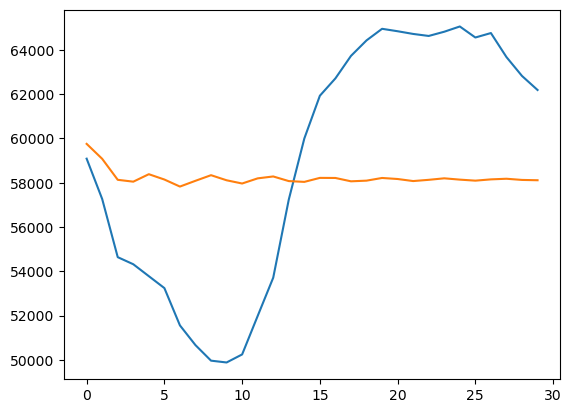

In [10]:
import matplotlib.pyplot as plt

x = np.arange(30)
plt.plot(x, y_test[:30], label="Ground Truth")
plt.plot(x, predictions[:30], label="Forecast")